In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import optax
import scipy.linalg
import scipy.signal
import torch
import matplotlib.pyplot as plt
from flax import linen as nn
from torch.utils.data import Dataset, DataLoader

def np_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [np_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

In [2]:
# Setup seed 
torch.random.manual_seed(0)
np.random.seed(0)
key = jax.random.PRNGKey(0)

In [3]:
A = np.array([[0,1],[0,0]])
B = np.array([[0],[1]])
Q = np.array([[1,0],[0,1]])
R = np.array([[0.01]])
R_inv = scipy.linalg.inv(R)

P = scipy.linalg.solve_continuous_are(A,B,Q,R)

Build dynamics simulation

In [4]:
dt = 0.01
state_dim = A.shape[0]
u_dim = B.shape[1]
A_d, B_d, _, _, _ = scipy.signal.cont2discrete((A, B, np.eye(state_dim), np.eye(u_dim)), dt=dt)

def dynamics_step(x, u):
    return A_d @ x + B_d @ u


In [5]:
class PSDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(128, use_bias=False)(x)
        y = jnp.sin(y)
        y = nn.Dense(128, use_bias=False)(y)
        y = jnp.sin(y)
        y = nn.Dense(64, use_bias=False)(y)
        y = jnp.einsum('...i,...i->...', y, y) + 1e-3 * jnp.einsum('...i,...i->...', x, x)

        return y.squeeze()
    
class SoftPSDValueApproximator(nn.Module):
    @nn.compact
    def __call__(self, x):
        y = nn.Dense(128)(x)
        y = jnp.sin(y)
        y = nn.Dense(128)(y)
        y = jnp.sin(y)
        y = nn.Dense(64)(y)
        y = nn.Dense(1)(y)

        return y.squeeze()

Generate datasets

In [6]:
metric = 1e-4
xs = np.random.uniform(low=-1,high=1, size=(2**16, 2))
norms = np.array([x.T @ x for x in xs])
running_costs = np.where(norms > metric, 1, 0)

class StateDataset(Dataset):
    def __init__(self, xs, running_costs):
        super().__init__()
        self.xs = xs
        self.running_costs = running_costs
    def __len__(self):
        return self.xs.shape[0]
    def __getitem__(self, index):
        return self.xs[index], self.running_costs[index]
    
dataset = StateDataset(xs, running_costs)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=np_collate, drop_last=False)

Code for evaluate average cumulated costs

In [7]:
def get_mean_and_std_of_policy(model, model_params, model_states, num_of_trajectory = 20, max_T=15):
    
    @jax.jit
    def get_control(x):
        v_gradient, _ = jax.grad(model.apply, argnums=1, has_aux=True)({'params': model_params, **model_states}, x, mutable=list(model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u
    
    ts = np.arange(0, max_T, dt)
    optimal_cutting_time_list = []

    for i in range(num_of_trajectory):
        x = np.random.uniform(low=-1,high=1, size=(2,))
        for t in ts:
            if x.T @ x <= metric:
                optimal_cutting_time_list.append(t)
                break
            u = np.array(get_control(x))
            x = dynamics_step(x, u)
        if t >= max_T - dt:
            optimal_cutting_time_list.append(max_T)
    
    optimal_cutting_time_list = np.array(optimal_cutting_time_list)

    return np.mean(optimal_cutting_time_list), np.std(optimal_cutting_time_list)

Code for training PSD value function

In [8]:
psd_value_function_approximator = PSDValueApproximator()
key, key_to_use = jax.random.split(key)
psd_model_variables = psd_value_function_approximator.init(key_to_use, jnp.zeros((1,2)))
psd_model_states, psd_model_params = psd_model_variables.pop('params')
del psd_model_variables
psd_optimizer = optax.adam(learning_rate=1e-3)
psd_optimizer_states = psd_optimizer.init(psd_model_params)

psd_cumulated_cost_during_learning_mean = []
psd_cumulated_cost_during_learning_std = []

def psd_hjb_loss(params, states, xs, running_costs):
    def get_v_gradient(params, states, x):
        return jax.grad(psd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def loss(x, running_cost):
        v_gradient, updated_states = get_v_gradient(params, states, x)
        u = -jnp.sign(v_gradient @ B) 
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + running_cost)
        return loss, updated_states    
    batch_losses, updated_states = jax.vmap(loss)(xs, running_costs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def psd_params_update(params, states, optimizer_state, xs, running_costs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(psd_hjb_loss, has_aux=True)(params, states, xs, running_costs)
    updates, optimizer_state = psd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

psd_losses = []
for epoch in range(100):
    
    psd_total_loss = 0

    psd_cumulated_cost_mean, psd_cumulated_cost_std = get_mean_and_std_of_policy(psd_value_function_approximator, psd_model_params, psd_model_states)
    psd_cumulated_cost_during_learning_mean.append(psd_cumulated_cost_mean)
    psd_cumulated_cost_during_learning_std.append(psd_cumulated_cost_std)

    for i, (xs, running_costs) in enumerate(dataloader):
        psd_model_params, psd_model_states, psd_optimizer_states, psd_loss = psd_params_update(psd_model_params, psd_model_states, psd_optimizer_states, xs, running_costs)
        psd_total_loss += psd_loss
    psd_losses.append(psd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{psd_total_loss / len(dataloader)}")

psd_cumulated_cost_during_learning_mean = np.array(psd_cumulated_cost_during_learning_mean)
psd_cumulated_cost_during_learning_std = np.array(psd_cumulated_cost_during_learning_std)


epoch:10 loss:0.07184618711471558
epoch:20 loss:0.05127125605940819
epoch:30 loss:0.050909679383039474
epoch:40 loss:0.044496916234493256
epoch:50 loss:0.035330913960933685
epoch:60 loss:0.04974454268813133
epoch:70 loss:0.02857941947877407
epoch:80 loss:0.025896722450852394
epoch:90 loss:0.025598838925361633
epoch:100 loss:0.026374680921435356


Code for training value function with soft PSD method

In [9]:
regularization = 1e0
soft_psd_value_function_approximator = SoftPSDValueApproximator()
key, key_to_use = jax.random.split(key)
soft_psd_model_variables = soft_psd_value_function_approximator.init(key_to_use, jnp.zeros((1,2)))
soft_psd_model_states, soft_psd_model_params = soft_psd_model_variables.pop('params')
del soft_psd_model_variables
soft_psd_optimizer = optax.adam(learning_rate=1e-3)
soft_psd_optimizer_states = soft_psd_optimizer.init(soft_psd_model_params)

soft_psd_cumulated_cost_during_learning_mean = []
soft_psd_cumulated_cost_during_learning_std = []

def soft_psd_hjb_loss(params, states, xs, running_costs):
    def get_v_gradient(params, states, x):
        return jax.value_and_grad(soft_psd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def get_v_at_zeros(params, states, x):
        return soft_psd_value_function_approximator.apply({'params': params, **states}, jnp.zeros_like(x))
    def loss(x, running_cost):
        (value, updated_states), v_gradient = get_v_gradient(params, states, x)
        value_at_zeros = get_v_at_zeros(params, states, x)
        u = -jnp.sign(v_gradient @ B) 
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + running_cost) + regularization * jnp.maximum(0, value_at_zeros-value)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs, running_costs)
    return jnp.mean(batch_losses), updated_states

def soft_psd_warmup_hjb_loss(params, states, xs, running_costs):
    def get_v_gradient(params, states, x):
        return jax.value_and_grad(soft_psd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': params, **states}, x, mutable=list(states.keys()))
    def get_v_at_zeros(params, states, x):
        return soft_psd_value_function_approximator.apply({'params': params, **states}, jnp.zeros_like(x))
    def loss(x, running_cost):
        (value, updated_states), v_gradient = get_v_gradient(params, states, x)
        value_at_zeros = get_v_at_zeros(params, states, x)
        u = jnp.clip(-R_inv @ B.T @ P @ x, -1, 1)
        x_dot = A @ x + B @ u
        v_dot = v_gradient.T @ x_dot
        loss = jnp.abs(v_dot + running_cost) + regularization * jnp.maximum(0, value_at_zeros-value)
        return loss, updated_states
    batch_losses, updated_states = jax.vmap(loss)(xs, running_costs)
    return jnp.mean(batch_losses), updated_states

@jax.jit
def soft_psd_params_update(params, states, optimizer_state, xs, running_costs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(soft_psd_hjb_loss, has_aux=True)(params, states, xs, running_costs)
    updates, optimizer_state = soft_psd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

@jax.jit
def soft_psd_params_warmup_update(params, states, optimizer_state, xs, running_costs):
    (loss, updated_states), hjb_grad = jax.value_and_grad(soft_psd_warmup_hjb_loss, has_aux=True)(params, states, xs, running_costs)
    updates, optimizer_state = soft_psd_optimizer.update(hjb_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    return params, updated_states, optimizer_state, loss

soft_psd_losses = []
warmup_epochs = 20
epochs = 100
for warmup_epoch in range(warmup_epochs):
    soft_psd_total_loss = 0

    soft_psd_cumulated_cost_mean, soft_psd_cumulated_cost_std = get_mean_and_std_of_policy(soft_psd_value_function_approximator, soft_psd_model_params, soft_psd_model_states)
    soft_psd_cumulated_cost_during_learning_mean.append(soft_psd_cumulated_cost_mean)
    soft_psd_cumulated_cost_during_learning_std.append(soft_psd_cumulated_cost_std)

    for i, (xs, running_costs) in enumerate(dataloader):
        soft_psd_model_params, soft_psd_model_states, soft_psd_optimizer_states, soft_psd_loss = soft_psd_params_warmup_update(soft_psd_model_params, soft_psd_model_states, soft_psd_optimizer_states, xs, running_costs)
        soft_psd_total_loss += soft_psd_loss
    soft_psd_losses.append(soft_psd_total_loss / len(dataloader))
    if (warmup_epoch+1) % 10 == 0:
        print(f"epoch:{warmup_epoch+1} loss:{soft_psd_total_loss / len(dataloader)}")

for epoch in range(warmup_epochs, epochs, 1):
    soft_psd_total_loss = 0

    soft_psd_cumulated_cost_mean, soft_psd_cumulated_cost_std = get_mean_and_std_of_policy(soft_psd_value_function_approximator, soft_psd_model_params, soft_psd_model_states)
    soft_psd_cumulated_cost_during_learning_mean.append(soft_psd_cumulated_cost_mean)
    soft_psd_cumulated_cost_during_learning_std.append(soft_psd_cumulated_cost_std)

    for i, (xs, running_costs) in enumerate(dataloader):
        soft_psd_model_params, soft_psd_model_states, soft_psd_optimizer_states, soft_psd_loss = soft_psd_params_update(soft_psd_model_params, soft_psd_model_states, soft_psd_optimizer_states, xs, running_costs)
        soft_psd_total_loss += soft_psd_loss
    soft_psd_losses.append(soft_psd_total_loss / len(dataloader))
    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1} loss:{soft_psd_total_loss / len(dataloader)}")

soft_psd_cumulated_cost_during_learning_mean = np.array(soft_psd_cumulated_cost_during_learning_mean)
soft_psd_cumulated_cost_during_learning_std = np.array(soft_psd_cumulated_cost_during_learning_std)


epoch:10 loss:0.07253070920705795
epoch:20 loss:0.04990249127149582
epoch:30 loss:0.038692742586135864
epoch:40 loss:0.030903887003660202
epoch:50 loss:0.026072364300489426
epoch:60 loss:0.024785464629530907
epoch:70 loss:0.02323445864021778
epoch:80 loss:0.02199781872332096
epoch:90 loss:0.021399883553385735
epoch:100 loss:0.020772665739059448


Make plots

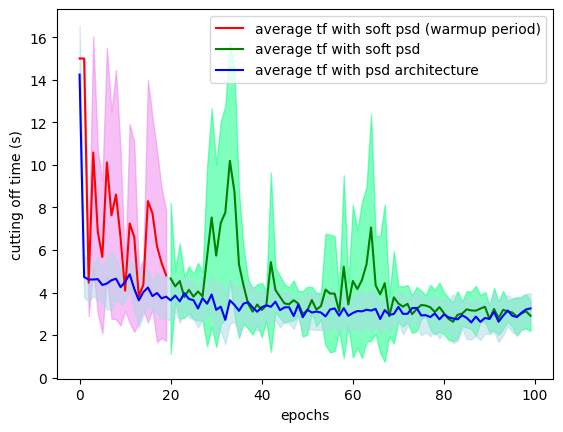

In [10]:
plt.figure()

plt.plot(soft_psd_cumulated_cost_during_learning_mean[:warmup_epochs], color="red", label="average tf with soft psd (warmup period)")
plt.fill_between(range(warmup_epochs),
                soft_psd_cumulated_cost_during_learning_mean[:warmup_epochs]+soft_psd_cumulated_cost_during_learning_std[:warmup_epochs], 
                soft_psd_cumulated_cost_during_learning_mean[:warmup_epochs] - soft_psd_cumulated_cost_during_learning_std[:warmup_epochs],
                color="violet", alpha=0.5)

plt.plot(range(warmup_epochs, epochs), soft_psd_cumulated_cost_during_learning_mean[warmup_epochs:], color="green", label="average tf with soft psd")
plt.fill_between(range(warmup_epochs, epochs),
                soft_psd_cumulated_cost_during_learning_mean[warmup_epochs:]+soft_psd_cumulated_cost_during_learning_std[warmup_epochs:], 
                soft_psd_cumulated_cost_during_learning_mean[warmup_epochs:] - soft_psd_cumulated_cost_during_learning_std[warmup_epochs:],
                color="springgreen", alpha=0.5)

plt.plot(psd_cumulated_cost_during_learning_mean, color="blue", label="average tf with psd architecture")
plt.fill_between(range(len(psd_cumulated_cost_during_learning_mean)), 
                 psd_cumulated_cost_during_learning_mean+psd_cumulated_cost_during_learning_std, 
                 psd_cumulated_cost_during_learning_mean-psd_cumulated_cost_during_learning_std, color="lightblue", alpha=0.5)

plt.legend()
plt.xlabel("epochs")
plt.ylabel("cutting off time (s)")
plt.show()

Test policy

In [11]:
def test_learned_policy(x0, T=10):

    @jax.jit
    def get_psd_control(x):
        v_gradient, _ = jax.grad(psd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': psd_model_params, **psd_model_states}, x, mutable=list(psd_model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u
    
    @jax.jit
    def get_soft_psd_control(x):
        v_gradient, _ = jax.grad(soft_psd_value_function_approximator.apply, argnums=1, has_aux=True)({'params': soft_psd_model_params, **soft_psd_model_states}, x, mutable=list(soft_psd_model_states.keys()))
        u = -jnp.sign(v_gradient @ B) 
        return u

    ts = np.arange(0, T, dt)
    xs_psd = [x0]
    xs_soft_psd = [x0]
    xs_lqr = [x0]
    us_psd = []
    us_soft_psd = []
    us_lqr = []
    optimal_t_lqr = T
    optimal_t_psd = T
    optimal_t_soft_psd = T

    for t in ts:
        us_psd.append(np.array(get_psd_control(xs_psd[-1])))
        xs_psd.append(dynamics_step(xs_psd[-1], us_psd[-1]))
        if xs_psd[-1].T @ xs_psd[-1] <= metric:
            optimal_t_psd = min(t, optimal_t_psd)

        us_soft_psd.append(np.array(get_soft_psd_control(xs_soft_psd[-1])))
        xs_soft_psd.append(dynamics_step(xs_soft_psd[-1], us_soft_psd[-1]))
        if xs_soft_psd[-1].T @ xs_soft_psd[-1] <= metric:
            optimal_t_soft_psd = min(t, optimal_t_soft_psd) 

        us_lqr.append(np.clip(-R_inv @ B.T @ P @ xs_lqr[-1], -1, 1))
        xs_lqr.append(dynamics_step(xs_lqr[-1], us_lqr[-1]))
        if xs_lqr[-1].T @ xs_lqr[-1] <= metric:
            optimal_t_lqr = min(t, optimal_t_lqr)
    
    xs_psd = np.array(xs_psd)
    us_psd = np.array(us_psd)
    xs_soft_psd = np.array(xs_soft_psd)
    us_soft_psd = np.array(us_soft_psd)
    xs_lqr = np.array(xs_lqr)
    us_lqr = np.array(us_lqr)

    plt.figure()
    plt.plot(ts, xs_psd[:-1, 0], '-.', color = 'blue', label="pos with psd architecture")
    plt.plot(ts, xs_psd[:-1, 1], '-', color = 'blue', label="vel with psd architecture")
    plt.plot(ts, xs_lqr[:-1, 0], '-.', color = 'red', label="pos lqr")
    plt.plot(ts, xs_lqr[:-1, 1], '-', color='red', label="vel lqr")
    plt.plot(ts, xs_soft_psd[:-1, 0], '-.', color = 'green', label="pos with soft psd")
    plt.plot(ts, xs_soft_psd[:-1, 1], '-', color = 'green', label="vel with soft psd")

    plt.vlines(optimal_t_psd, -0.7, 0.7, 'b', linestyles='dashed', label="tf with psd architecture")
    plt.vlines(optimal_t_lqr, -0.7, 0.7, 'r', linestyles='dashed', label="tf lqr")
    plt.vlines(optimal_t_soft_psd, -0.7, 0.7, 'g', linestyles='dashed', label="tf with soft psd")

    plt.legend(loc="upper right")
    plt.xlabel("time")
    plt.ylabel("states")
    plt.title("double integrator optimal time control")

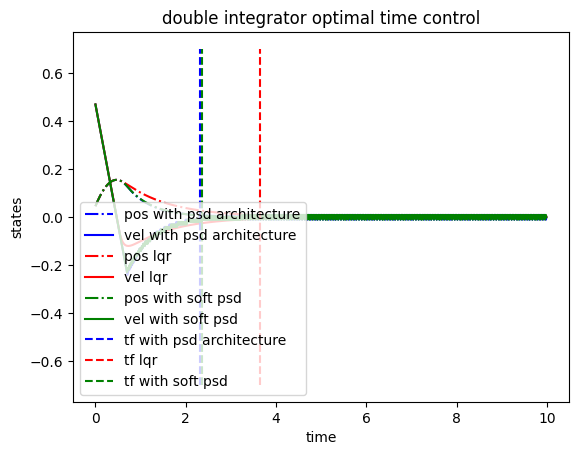

In [12]:
x0 = np.random.uniform(low=-1,high=1, size=(2,))
test_learned_policy(x0)

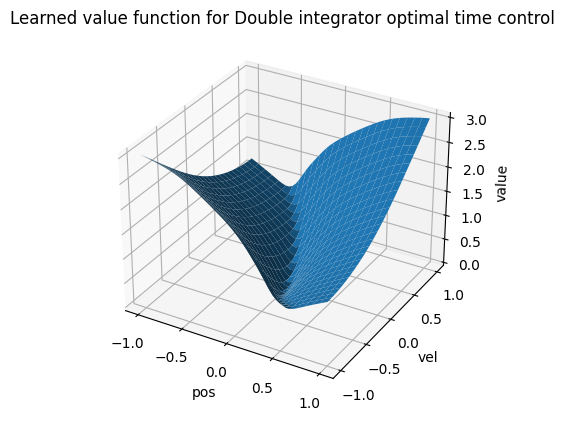

In [13]:
def visualize_learned_value_landscope(model, model_params, model_states, x_direction, y_direction, 
                        x_range=np.linspace(-1, 1, 51), y_range=np.linspace(-1, 1, 51), title="Learned value function"):
    """
    This function help to draw value function landscope for learn function,
    
    x_direction and y_direction should be perpenticular to each other, suppose a_i \in x_range, b_i \in y_range, then x_i = a_i * x_direction + b_i * y_direction.
    This is prepare for visualize state dimension higher than 2.

    Args:
        model: nn network object
        model_params: params for learned nn networks
        model_states: params for neural network states such as bn statistics
        x_direction: x axis direction
        y_direction: y axis direction
        x_range: the ranges for x direction
        y_range: the range for y direction
    """
    

    quick_apply = jax.jit(model.apply, static_argnames=["train"])
    X, Y = np.meshgrid(x_range, y_range)
    v_learned = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(Y.shape[1]):
            x = X[i,j] * x_direction
            x += Y[i,j] * y_direction
            v_learned[i,j] = quick_apply({"params":model_params, **model_states}, x)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, v_learned)
    ax.set_xlabel(f"pos")
    ax.set_ylabel(f"vel")
    ax.set_zlabel('value')
    plt.title(title)


x_direction = np.array([1,0])
y_direction = np.array([0,1])
visualize_learned_value_landscope(psd_value_function_approximator, psd_model_params, psd_model_states, x_direction=x_direction, y_direction=y_direction, title="Learned value function for Double integrator optimal time control")